In [36]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path

In [37]:
# Constants
IMAGE_SIZE = (416, 416)  # Input size for YOLOv8
BATCH_SIZE = 16  # Number of samples per batch

In [38]:
# Path to the dataset
TRAIN_IMAGES_DIR = "dataset/train/images/"
TRAIN_LABELS_DIR = "dataset/train/labels/"

VAL_IMAGES_DIR = "dataset/val/images/"
VAL_LABELS_DIR = "dataset/val/labels/"

In [39]:
# Function to load and preprocess images
def load_image(image_path):
    if isinstance(image_path, tf.Tensor):  # Check if it's a TensorFlow tensor
        image_path = image_path.numpy().decode("utf-8")  # Convert to string
    image = Image.open(image_path).resize(IMAGE_SIZE)  # Resize
    image = np.array(image) / 255.0  # Normalize
    return image.astype(np.float32)

In [40]:
# Function to load and parse YOLO annotations
def load_yolo_annotations(label_path):
    if isinstance(label_path, tf.Tensor):
        label_path = label_path.numpy().decode("utf-8")
    
    annotations = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ")
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Convert YOLO to bounding box format
            x_min = (x_center - width / 2) * IMAGE_SIZE[0]
            y_min = (y_center - height / 2) * IMAGE_SIZE[1]
            x_max = (x_center + width / 2) * IMAGE_SIZE[0]
            y_max = (x_center + height / 2) * IMAGE_SIZE[1]

            annotations.append([x_min, y_min, x_max, y_max, class_id])

    return np.array(annotations, dtype=np.float32)

In [41]:
# Function to load image and corresponding annotations
def load_sample(image_path):
    if isinstance(image_path, tf.Tensor):
        image_path = image_path.numpy().decode("utf-8")  # Explicit conversion to string
    
    image = load_image(image_path)
    label_path = TRAIN_LABELS_DIR + Path(image_path).stem + ".txt"  # Now label_path is a valid string
    annotations = load_yolo_annotations(label_path)
    return image, annotations


In [42]:
def data_loader(images_dir, batch_size):
    image_paths = list(Path(images_dir).rglob("*.jpg"))  # Get all image paths
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])

    # Map function to load images and annotations
    dataset = dataset.map(
        lambda x: tf.py_function(
            load_sample, [x], [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Apply batching and prefetching
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [43]:
# Create training dataset
train_dataset = data_loader(TRAIN_IMAGES_DIR, BATCH_SIZE)

# Test if the dataset can be iterated over without errors
for batch in train_dataset:
    images, labels = batch  # Verify the output
    print("Image batch shape:", images.shape)  # Should be (BATCH_SIZE, 416, 416, 3)
    print("Labels batch shape:", labels.shape)  # Varies based on annotations


Image batch shape: (1, 416, 416, 3)
Labels batch shape: (1, 1, 5)


In [26]:
# Install necessary visualization libraries
!pip install matplotlib

DEPRECATION: Loading egg at c:\users\acer\anaconda3\envs\object_detection\lib\site-packages\avro_python3-1.10.2-py3.9.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [44]:
import keras_cv
import matplotlib.pyplot as plt
import keras_cv.visualization as visualization

In [49]:
# Function to separate class IDs from bounding box coordinates
def extract_bounding_box_info(bounding_boxes_raw):
    # Check if the last dimension has five elements
    if bounding_boxes_raw.shape[-1] == 5:
        # Extract the class ID (last element) and bounding box coordinates
        class_ids = bounding_boxes_raw[..., -1]  # The last element is the class ID
        bounding_boxes = bounding_boxes_raw[..., :-1]  # The rest is the bounding box coordinates
    else:
        raise ValueError(f"Unexpected bounding box shape: {bounding_boxes_raw.shape}")
    return bounding_boxes, class_ids

In [52]:
# Function to visualize bounding boxes in a gallery format
def visualize_dataset(dataset, value_range, default_rows, default_cols, bounding_box_format):
    # Get the first batch from the dataset
    batch = next(iter(dataset.take(1)))  # Get the first batch
    
    # Extract images and raw bounding boxes
    images, bounding_boxes_raw = batch
    
    # Ensure there are images to plot
    if images.shape[0] == 0:
        raise ValueError("No images found in the dataset.")

    # If there's only one image, adjust rows and columns
    total_images = images.shape[0]
    rows = min(default_rows, total_images)  # Adjust rows based on available images
    cols = math.ceil(total_images / rows)  # Adjust columns based on rows and total images

    # Extract bounding boxes and class IDs
    bounding_boxes, class_ids = extract_bounding_box_info(bounding_boxes_raw)

    # Convert bounding box format
    bounding_boxes = keras_cv.bounding_box.convert_format(
        bounding_boxes,
        source=bounding_box_format,
        target="xywh",
    )

    # Create class mappings for visualization
    class_mapping = {int(cls): f"Class {cls}" for cls in np.unique(class_ids)}  # Adjust for your dataset
    
    # Plot bounding boxes on images
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true={
            "classes": class_ids,
            "boxes": bounding_boxes,
        },
        scale=5,
        font_scale=0.7,
        bounding_box_format="xywh",
        class_mapping=class_mapping,
    )

In [55]:
import math

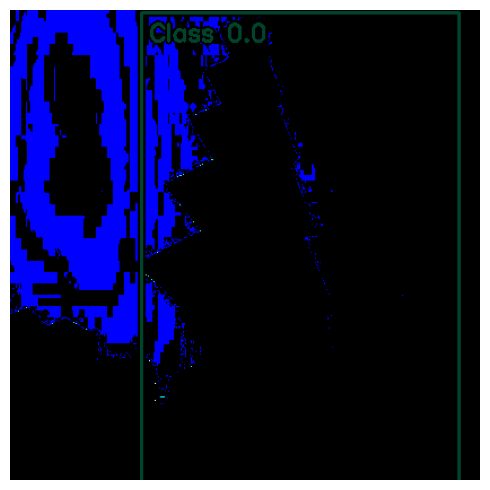

In [58]:
# Create training dataset
train_dataset = data_loader(TRAIN_IMAGES_DIR, BATCH_SIZE)

# Test visualization with updated dynamic row/column size
visualize_dataset(train_dataset, value_range=(0, 1), default_rows=2, default_cols=2, bounding_box_format="xywh")


In [48]:
# Create training dataset
train_dataset = data_loader(TRAIN_IMAGES_DIR, BATCH_SIZE)

# Retrieve the first batch to inspect
first_batch = next(iter(train_dataset.take(1)))
images, bounding_boxes = first_batch

# Display the shapes of the outputs
print("Images shape:", images.shape)  # Should be (BATCH_SIZE, height, width, channels)
print("Bounding boxes shape:", bounding_boxes.shape)  # Expected (BATCH_SIZE, num_boxes, 5 or 4)


Images shape: (1, 416, 416, 3)
Bounding boxes shape: (1, 1, 5)
